# Tutorial On Data Manipulation and analysis

This tutorial is directly extracted from a jupyter notebook used to illustrate how to get your data back from a PyMoDAQ h5 file, analyze it and plot interactively these data.

The analysis below is made on data taken from a Master student practical work. They had to setup and acquire a femtosecond pump-probe experiment on a gold thin film. The measured dynamic shows the electronic absorption of light from the pump laser, the quick thermalization of the electron gas with the gold film phonons and finally the expansions/contractions oscillations of the film due to the non-adiabatic energy transfer. To see the phonons oscillations, one need to repeat the pump-probe scan many times and average the data. The author thank Dr Arnaud Arbouet for the data and explanations. And if you don't understand the physics, it's not an issue as this notebook is here to show you how to load, manipulate and easily plot your data.

![python](analysis_data/setup.png)



*Requirements:*
To execute this tutorial properly, you'll need:

* *pymodaq_data* >= 5.0.3 (if not released yet, you can get it from github)
* *matplotlib* for ploting data using it
* *pymodaq_gui* >= 5.0.2 for plotting data using Qt based pymodaq data viewers

* An installation of *jupyter lab*, (see [here](https://pymodaq.cnrs.fr/tutorials/jupyter_lab.html) for a tutorial)

In [2]:
%gui qt5 
# magic keyword only used to start a qt event loop within the jupyter notebook framwork

# importing built in modules
from pathlib import Path
import sys

# importing third party modules
import numpy as np

# importing PymoDAQ modules
from pymodaq_data.h5modules.saving import H5SaverLowLevel  # object to open the h5 file
from pymodaq_data.h5modules.data_saving import DataLoader  # object used to properly load data from the h5 file
from pymodaq_data.data import DataRaw, DataToExport, Axis
from pymodaq_gui.plotting.data_viewers.viewerND import ViewerND

from pymodaq_data import __version__
print(__version__)

from pymodaq_gui import __version__
print(__version__)

LIGHT_SPEED = 299792458  # m/s
SOUND_SPEED_GOLD = 3240  # m/s


5.0.3
5.0.2


# Loading Data

In [3]:
dwa_loader = DataLoader('analysis_data/data.h5') # this way of loading data directly from a Path is 
#available from pymodaq>=4.2.0

for node in dwa_loader.walk_nodes():
    if 'Scan012' in str(node):
        print(node)



/RawData/Scan012 (GROUP) 'DAQScan'
/RawData/Scan012/Actuator000 (GROUP) 'delay'
/RawData/Scan012/Detector000 (GROUP) 'Lockin'
/RawData/Scan012/NavAxes (GROUP) ''
/RawData/Scan012/Detector000/Data0D (GROUP) ''
/RawData/Scan012/NavAxes/Axis00 (CARRAY) 'delay'
/RawData/Scan012/NavAxes/Axis01 (CARRAY) 'Average'
/RawData/Scan012/Detector000/Data0D/CH00 (GROUP) 'MAG'
/RawData/Scan012/Detector000/Data0D/CH01 (GROUP) 'PHA'
/RawData/Scan012/Detector000/Data0D/CH00/Data00 (CARRAY) 'MAG'
/RawData/Scan012/Detector000/Data0D/CH01/Data00 (CARRAY) 'PHA'


To load a particular node, use the `load_data` method

In [4]:
dwa_loaded = dwa_loader.load_data('/RawData/Scan012/Detector000/Data0D/CH00/Data00')
print(dwa_loaded)


<DataWithAxes: MAG <u: > <len:1> (100, 392|)>


## Plotting data

From PyMoDAQ 4.0.2 onwards, both the DataWithAxes (and its inheriting children classes) and the DataToExport objects have a `plot` method. One can specify as argument which backend to be used for plotting. At least two are available: `matplotlib` and `qt`. See below

Using *matplotlib*:

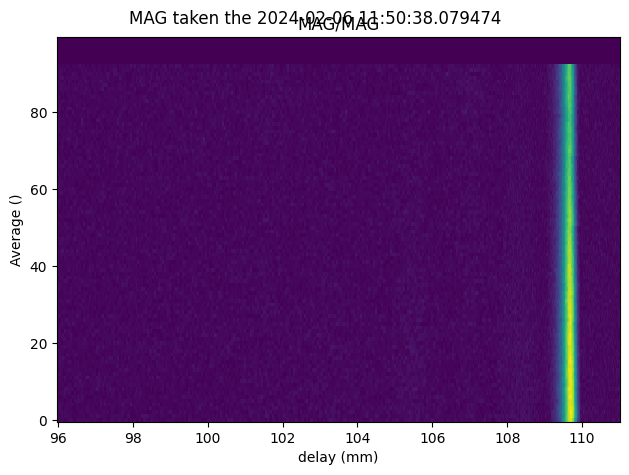

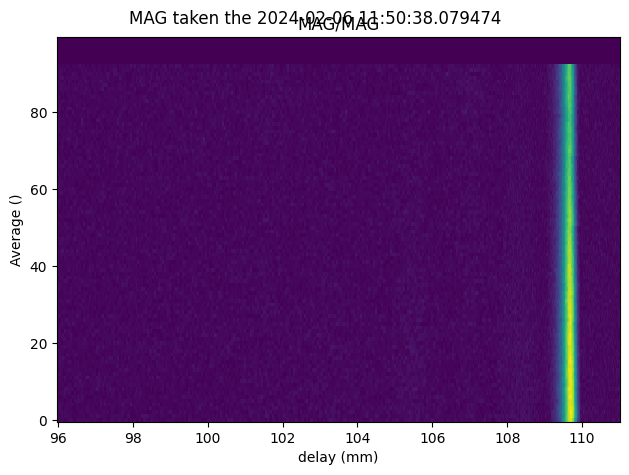

In [6]:
dwa_loaded.nav_indexes = ()  # this is converting both navigation axes: average and delay as signal axes (to be plotted in the Viewer2D)
dwa_loaded.plot('matplotlib')

Using PyMoDAQ's data viewer (interactive and with ROIs and all other features)

![python](analysis_data/data_femto.png)

The horizontal axis is a delay in millimeter (linear stage displacement, see setup) and we used a Sparsed scan with a non equal scan step (see figure below, right panel). This non linear step is why the 2D plot is different from the 1D extracted from the ROI (see above). Basically, 2D data with non linear axes cannot be plotted on a Viewer2D because this one is dedicated to uniform data and linear axes.

In [9]:
delay_axis = dwa_loaded.get_axis_from_index(1)[0]
dte = dwa_loaded.as_dte('mydata')
dte.append(DataRaw(delay_axis.label, data=[delay_axis.get_data()]))
dte.plot('qt')

![python](analysis_data/data_femto_and_spread_axis.png)

In [10]:
dwa_loaded_steps = dwa_loaded.deepcopy()
delay_axis = dwa_loaded_steps.get_axis_from_index(1)[0]
delay_axis.data = delay_axis.create_simple_linear_data(len(delay_axis))
delay_axis.label = 'steps'
delay_axis.units = ''

This delay axis is for the moment in mm and reversed (the stage is going backwards to increase the delay). Let's recreate a flipped axis with seconds as units.

In [11]:
dwa_loaded_fs = dwa_loaded.deepcopy()
delay_axis = dwa_loaded_fs.get_axis_from_index(1)[0]
delay_axis.data = - 2 * delay_axis.get_data() / 1000 / LIGHT_SPEED  # /1000 because the dsiplacement unit
# of the stage is in mm and the speed of light in m/s
delay_axis.data -= delay_axis.get_data()[0]
delay_axis.units = 's'
print(delay_axis.get_data()[0:10])

[0.00000000e+00 1.33425638e-13 2.66851276e-13 4.00276914e-13
 5.33702552e-13 6.67128190e-13 8.00553828e-13 9.33979467e-13
 1.06740510e-12 1.20083074e-12]


In [12]:
dwa_loaded_fs.plot('qt')

In [16]:
dwa_loader.get_node('/RawData/Scan012/NavAxes/Axis00')[:] = delay_axis.get_data()
dwa_loader.get_node('/RawData/Scan012/Detector000/Data0D/CH00/Data00')[:] = dwa_loaded_fs[0]
dwa_loader.close_file()


![python](analysis_data/data_femto_fs.png)

# Data Analysis

Now we got our data, one can extract infos from it

* life-time of the electrons -> phonons thermalization
* Oscillation period of the phonons vibration

To do this, one will properly slice the data correpsonding to the electrons and the one corresponding to the phonons. To get the scan index to use for slicing, one will plot the raw data as a function of scan steps and extract the index using ROIs

In [ ]:
dwa_loaded_steps.plot('qt')

![python](analysis_data/data_femto_roi.png)

The ROi Manager (on the right, not visible here) tell us to use:

In [ ]:
indexes_electrons = (70, 390)
indexes_phonons = (100, 300)
indexes_average = (0, 40) # we are not using all the averaging because the gold film seems
# to be dying as time goes on...

First we slice the data over the average indexes and the electron indexes
This is done easily using the `isig` slicer (sig for signal axes. For navigation one should use the `inav` slicer)

In [ ]:
dwa_electrons = dwa_loaded_fs.isig[slice(*indexes_average), slice(*indexes_electrons)].mean(0)
print(dwa_electrons)

dwa_phonons = dwa_loaded_fs.isig[slice(*indexes_average), slice(*indexes_phonons)].mean(0)
print(dwa_phonons)

In [ ]:
dte = DataToExport('mydata', data=[dwa_electrons, dwa_phonons])
print(dte)
dte.plot('qt')

![python](analysis_data/data_femto_extracted.png)

## Fitting the Data

### Electrons:

In [ ]:
def my_lifetime(x, A, B, C, tau):
    return A + C * np.exp(-(x - B)/tau)

time_axis = dwa_electrons.axes[0].get_data()
initial_guess = (2e-7, 10e-12, 7e-6, 3e-11)

dwa_electrons_fitted = dwa_electrons.fit(my_lifetime, initial_guess=initial_guess)
dwa_electrons_fitted.append(dwa_electrons)
dwa_electrons_fitted.plot('qt')

![python](analysis_data/fit_electrons.png)

One get a life time of about:

In [ ]:
f'Life time: {dwa_electrons_fitted.fit_coeffs[0][3] *1e12} ps'

### Phonons:
For the phonons, it seems we have to analyse oscillations. The best for this is a Fourier Transform analysis. However because of the sparse scan the sampling at the begining is different from the one at the end. We'll have to resample our data on a regular grid before doing Fourier Transform

#### Resampling

In [ ]:
from pymodaq.utils import math_utils as mutils
from pymodaq.utils.data import Axis
phonon_axis_array = dwa_phonons.get_axis_from_index(0)[0].get_data()
phonon_axis_array -= phonon_axis_array[0]
time_step = phonon_axis_array[-1] - phonon_axis_array[-2]
time_array_linear = mutils.linspace_step(0, phonon_axis_array[-1], time_step)
dwa_phonons_interp = dwa_phonons.interp(time_array_linear)

dwa_phonons_interp.plot('qt')

#### FFT

In [ ]:
dwa_fft = dwa_phonons_interp.ft()

dwa_phonons_fft = DataToExport('FFT', data=[
    dwa_phonons_interp,
    dwa_fft.abs(),
    dwa_fft.abs(),
    dwa_fft.abs()])
dwa_phonons_fft.plot('qt')

![python](analysis_data/data_fft.png)

Temporal data and FFT amplitude (top). Zoom over the two first harmonics (bottom)

Using advanced math processors to extract data from dwa:


In [ ]:
from pymodaq.post_treatment.process_to_scalar import DataProcessorFactory
data_processors = DataProcessorFactory()
print('Implemented possible processing methods, can be applied to any data type and dimensionality')
print(data_processors.keys)
dwa_processed = data_processors.get('argmax').process(dwa_fft.abs())
print(dwa_processed[0])

or using builtin math methods applicable only to 1D data:

In [ ]:
dte_peaks = dwa_fft.abs().find_peaks(height=1e-6) 
print(dte_peaks[0].axes[0].get_data() / (2*np.pi))

dte_peaks[0].axes[0].as_dwa().plot('matplotlib', 'o-r')  # transforms an Axis object to dwa for quick plotting

dte_peaks[0].get_data_as_dwa(0).plot('matplotlib', 'o-b')  # select part of the data object for "selected" plotting

*From this one get a fundamental frequency of 5.32e10 Hz that corresponds to a period of:*

In [ ]:
T_phonons = 1/5.32e10
print(f'Period T = {T_phonons * 1e12} ps')

From this period and the speed of sound in gold, one can infer the gold film thickness:

In [ ]:
thickness = T_phonons / 2 * SOUND_SPEED_GOLD
print(f"Gold Thickness: {thickness * 1e9} nm")